In [68]:
import pandas as pd
from datetime import datetime,date
import pandas as pd
from pyspark.sql import Row
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *
import seaborn as sns
from pyspark.sql import SparkSession
import pandas as pd
from datetime import datetime, date
spark = SparkSession.builder.getOrCreate()
from pyspark.sql import functions as F
sparkContext = SparkSession.sparkContext

In [2]:
# change time zone to US Eastern time
import pytz
import time
import datetime
print(time.tzname)
dt_local = datetime.datetime.now(pytz.utc)
dt_us_eastern = dt_local.astimezone(pytz.timezone('America/New_York'))
print("US Eastern DateTime:", dt_us_eastern.strftime("%Y:%m:%d %H:%M:%S %Z %z"))

('¶«²¿±ê×¼Ê±¼ä', '¶«²¿ÏÄÁîÊ±')
US Eastern DateTime: 2023:03:12 01:48:56 EST -0500


In [3]:
# from pyspark.sql import SparkSession
# import pandas as pd
# from datetime import datetime, date
# spark = SparkSession.builder.enableHiveSupport().getOrCreate()

In [4]:
annualfeature = spark.read.format("csv").option("header", "true").load("annualfeature.csv")
annualday = spark.read.format("csv").option("header", "true").load("annualday.csv")
retailresponse = spark.read.format("csv").option("header", "true").load("retailresponse.csv")


In [5]:
annualjoin = annualfeature.join(annualday,["customer_id"], how = 'outer').join(retailresponse, ['customer_id'], how = 'outer')

In [6]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col

In [7]:
# # columns = data.columns[1:]
# # columns
# # for i in columns:
# #     data = data.withColumn(i, F.col(i).cast('double'))

# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.sql.functions import col

# # Load data
# data = annualjoin

# columns = data.columns[1:]

# for i in columns:
#     data = data.withColumn(i, F.col(i).cast('double'))
# data1 = data.drop('customer_id')
# data1 = data1.withColumnRenamed('response','label')
# # Define the features and target column names
# feature_cols = [col for col in data1.columns if col != "label"]
# target_col = "label"


# data1 = data1.na.fill(0)
# # Split data into training and test sets
# train_data, test_data = data1.randomSplit([1/3, 2/3], seed=1148)

## Logistic Regression Model of Annual Data

In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col

# Load data
data = annualjoin

columns = data.columns[1:]

for i in columns:
    data = data.withColumn(i, F.col(i).cast('double'))
data1 = data.drop('customer_id')
data1 = data1.withColumnRenamed('response','label')
# Define the features and target column names
feature_cols = [col for col in data1.columns if col != "label"]
target_col = "label"


data1 = data1.na.fill(0)
# Split data into training and test sets
train_data, test_data = data1.randomSplit([1/3, 2/3], seed=1148)


# Create the feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
vectrain = assembler.transform(train_data)
test_data = assembler.transform(test_data)
# ElasticNetParam = 1 => L1 regularization
lr = LogisticRegression(featuresCol="features", labelCol=target_col, elasticNetParam=1.0, regParam=0.1)
print('finished lr')
# Define parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.001, 0.01, 0.1])
              .build())
print('finished param_grid', param_grid)
# Create cross-validator object
cv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=BinaryClassificationEvaluator(), numFolds=3, seed = 1148)
print('finishend cv', cv)
# Fit the model on the training data
cv_model = cv.fit(vectrain)
print('finished cv_model')
# Make predictions on the test data
predictions = cv_model.transform(test_data)
print('finished preditions')
# Evaluate the model performance
evaluator = BinaryClassificationEvaluator(labelCol=target_col)
print('finished evaluator')
auc = evaluator.evaluate(predictions)

print("AUC:", auc)


finished lr
finished param_grid [{Param(parent='LogisticRegression_61c67a4347cb', name='regParam', doc='regularization parameter (>= 0).'): 0.001}, {Param(parent='LogisticRegression_61c67a4347cb', name='regParam', doc='regularization parameter (>= 0).'): 0.01}, {Param(parent='LogisticRegression_61c67a4347cb', name='regParam', doc='regularization parameter (>= 0).'): 0.1}]
finishend cv CrossValidator_b47239b66f13
finished cv_model
finished preditions
finished evaluator
AUC: 0.7687951540542746


In [76]:
best_model = cv_model.bestModel
print('Logistic regression of annual data:')
print(f"Best hyperparameters: regParam = {best_model._java_obj.getRegParam()}, elasticNetParam = {best_model._java_obj.getElasticNetParam()}, maxIter = {best_model._java_obj.getMaxIter()}")


Logistic regression of annual data:
Best hyperparameters: regParam = 0.01, elasticNetParam = 1.0, maxIter = 100


In [10]:
# import matplotlib.pyplot as plt

# # Get the coefficient values from the trained model
# coefficients = best_model.coefficients.toArray()

# # Plot the coefficient values
# plt.figure(figsize=(10, 5))
# plt.plot(coefficients)
# plt.xlabel("Feature Index")
# plt.ylabel("Coefficient Value")
# plt.title("Logistic Regression Coefficient Values")
# plt.show()

# # Get the feature importance values from the trained model
# importances = best_model.summary._java_obj.pValues

# # Plot the feature importance values
# plt.figure(figsize=(10, 5))
# plt.plot(importances)
# plt.xlabel("Feature Index")
# plt.ylabel("Feature Importance Value")
# plt.title("Logistic Regression Feature Importance")
# plt.show()


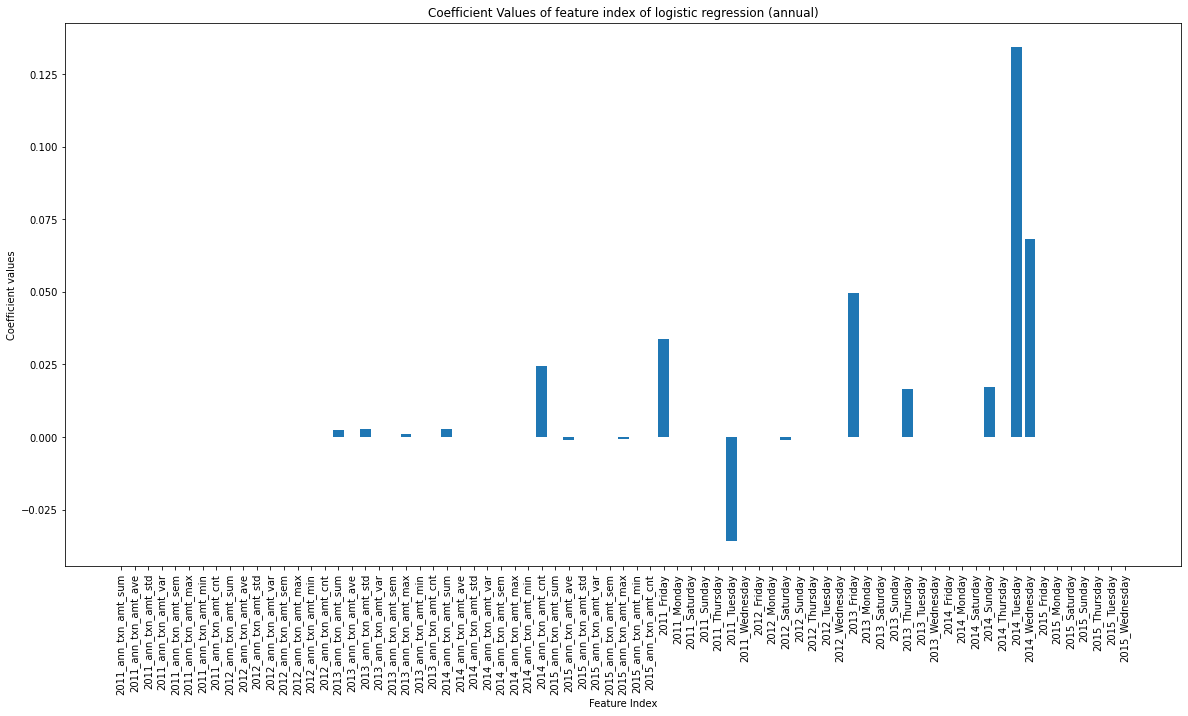

In [77]:
# Import necessary libraries

import matplotlib.pyplot as plt

# Load dataset




# Extract coefficient values and feature names
coefficients = best_model.coefficients
intercept = best_model.intercept
feature_names = data1.columns[0:len(data1.columns)-1]

# Plot coefficients
plt.figure(figsize=(20, 10))
plt.bar(feature_names,coefficients)
plt.xticks(rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Coefficient values')
plt.title("Coefficient Values of feature index of logistic regression (annual)")
plt.show()

# # Plot feature importance
# abs_coefficients = [abs(x) for x in coefficients]
# plt.bar(feature_names, abs_coefficients)
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.show()


Text(0.5, 1.0, 'Probability Distribution for Test Set of logistic regression (annual)')

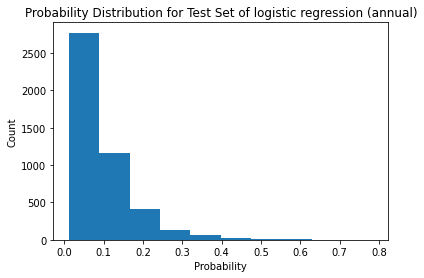

In [78]:
# from pyspark.ml.evaluation import BinaryLogisticRegressionSummary
from pyspark.ml.classification import BinaryLogisticRegressionSummary
import numpy as np
predictions = cv_model.transform(test_data)
test_probabilities = np.array(predictions.select('probability').collect())

plt.hist(test_probabilities[:,0][:,1], bins=10)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Probability Distribution for Test Set of logistic regression (annual)')
# summary = BinaryLogisticRegressionSummary(predictions, 'probability', 'label')
# Get the probability distribution for the test set
# prob_dist = summary.roc.toPandas()

# # Plot the probability distribution
# plt.plot(prob_dist['FPR'], prob_dist['TPR'])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Probability Distribution for Test Set')
# plt.show()

In [79]:
test_predictions = cv_model.transform(test_data)
train_predictions = cv_model.transform(vectrain)
train_labels = np.array(train_predictions.select('label').collect())
train_probabilities = np.array(train_predictions.select('probability').collect())
test_labels = np.array(test_predictions.select('label').collect())
test_probabilities = np.array(test_predictions.select('probability').collect())

#evaluator = BinaryClassificationEvaluator(labelCol=target_col)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target_col)
# Train set
train_accuracy = evaluator.evaluate(train_predictions)
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedPrecision'})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedRecall'})
train_confusion_matrix = train_predictions.groupBy('label', 'prediction').count()

# Test set
test_accuracy = evaluator.evaluate(test_predictions)
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedPrecision'})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedRecall'})
test_confusion_matrix = test_predictions.groupBy('label', 'prediction').count()

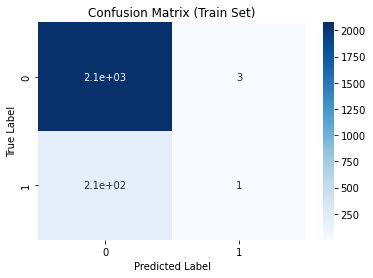

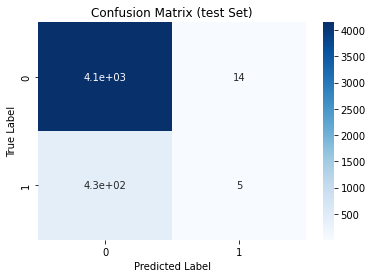

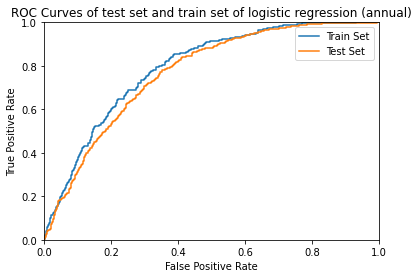

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
# Confusion matrix (train set)
#plt.imshow(train_confusion_matrix.toPandas(), cmap='Blues')
confusionmatrix = confusion_matrix(train_labels, np.array(train_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train Set)')
plt.show()
confusionmatrix = confusion_matrix(test_labels, np.array(test_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (test Set)')
plt.show()
# ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, train_probabilities[:,0][:, 1])
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, test_probabilities[:,0][:, 1])
plt.plot(train_fpr, train_tpr, label='Train Set')
plt.plot(test_fpr, test_tpr, label='Test Set')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of test set and train set of logistic regression (annual)')
plt.show()

In [15]:
print('Confusion matrix of test set: \n')
test_confusion_matrix.show()
print('Precision of test set: ', test_precision)
print('Recall of test set: ', test_recall)
print('\nConfusion matrix of train set: \n')
train_confusion_matrix.show()
print('Precision of train set: ', train_precision)
print('Recall of train set: ',train_recall)


Confusion matrix of test set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    5|
|  0.0|       1.0|   14|
|  1.0|       0.0|  428|
|  0.0|       0.0| 4149|
+-----+----------+-----+

Precision of test set:  0.8458792289513161
Recall of test set:  0.9038294168842472

Confusion matrix of train set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    1|
|  0.0|       1.0|    3|
|  1.0|       0.0|  213|
|  0.0|       0.0| 2076|
+-----+----------+-----+

Precision of train set:  0.8456351000452114
Recall of train set:  0.9058002616659397


## Decision Tree Model of Annual Data

In [16]:
# tree ex 2
# rough search decision tree parameters
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [10, 20, 30]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .build()
evaluator_dt = BinaryClassificationEvaluator(labelCol="label")
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=5, seed = 1148)
model_dt = cv_dt.fit(vectrain)
predictions = model_dt.transform(test_data)
auc = evaluator_dt.evaluate(predictions)
print("AUC = %g" % auc)


AUC = 0.582767


In [100]:
# show parameters after the rough tuning of decision tree model
best_model = model_dt.bestModel
print(f"Best hyperparameters: maxDepth = {best_model._java_obj.getMaxDepth()}, \
      maxBin = {best_model._java_obj.getMaxBins()}, \
      impurity = {best_model._java_obj.getImpurity()}")

Best hyperparameters: maxDepth = 10,       maxBin = 30,       impurity = gini


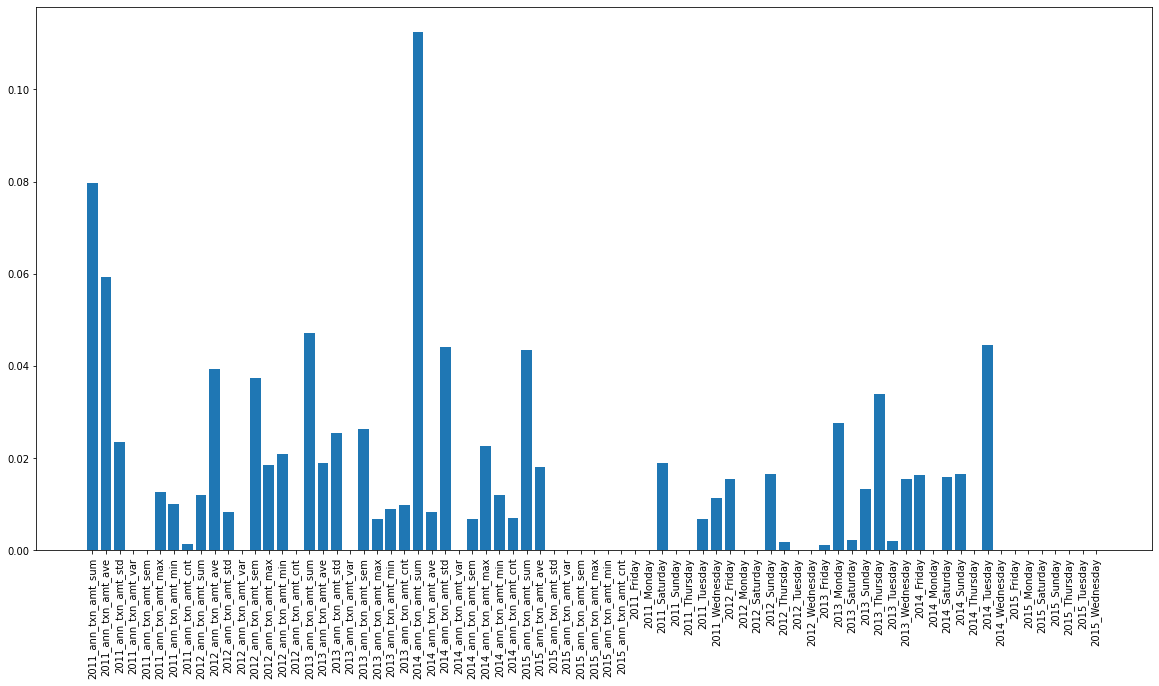

In [101]:
importances = best_model.featureImportances.toArray()
plt.figure(figsize=(20,10))
plt.bar(feature_names, importances)
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Probability Distribution for Test Set of decision tree (annual)')

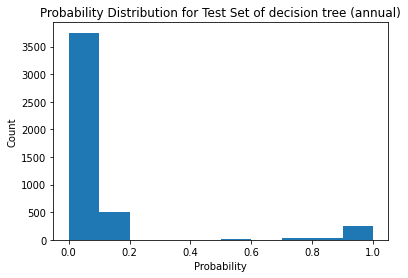

In [102]:
# probability distribution
predictions = model_dt.transform(test_data)
test_probabilities = np.array(predictions.select('probability').collect())

plt.hist(test_probabilities[:,0][:,1], bins=10)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Probability Distribution for Test Set of decision tree (annual)')

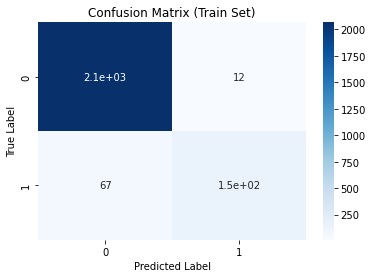

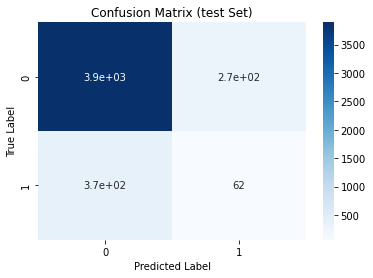

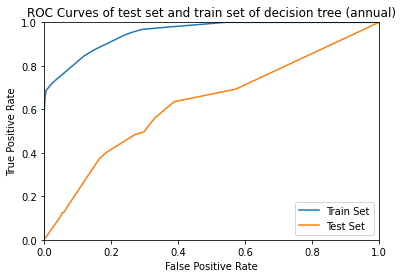

Confusion matrix of test set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   62|
|  0.0|       1.0|  273|
|  1.0|       0.0|  371|
|  0.0|       0.0| 3890|
+-----+----------+-----+

Precision of test set:  0.8443581488743573
Recall of test set:  0.8598781549173194

Confusion matrix of train set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  147|
|  0.0|       1.0|   12|
|  1.0|       0.0|   67|
|  0.0|       0.0| 2067|
+-----+----------+-----+

Precision of train set:  0.9644901267891343
Recall of train set:  0.9655473179241169


In [103]:
test_predictions = model_dt.transform(test_data)
train_predictions = model_dt.transform(vectrain)
train_labels = np.array(train_predictions.select('label').collect())
train_probabilities = np.array(train_predictions.select('probability').collect())
test_labels = np.array(test_predictions.select('label').collect())
test_probabilities = np.array(test_predictions.select('probability').collect())

#evaluator = BinaryClassificationEvaluator(labelCol=target_col)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target_col)
# Train set
train_accuracy = evaluator.evaluate(train_predictions)
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedPrecision'})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedRecall'})
train_confusion_matrix = train_predictions.groupBy('label', 'prediction').count()

# Test set
test_accuracy = evaluator.evaluate(test_predictions)
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedPrecision'})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedRecall'})
test_confusion_matrix = test_predictions.groupBy('label', 'prediction').count()


confusionmatrix = confusion_matrix(train_labels, np.array(train_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train Set)')
plt.show()
confusionmatrix = confusion_matrix(test_labels, np.array(test_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (test Set)')
plt.show()
# ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, train_probabilities[:,0][:, 1])
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, test_probabilities[:,0][:, 1])
plt.plot(train_fpr, train_tpr, label='Train Set')
plt.plot(test_fpr, test_tpr, label='Test Set')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of test set and train set of decision tree (annual)')
plt.show()
print('Confusion matrix of test set: \n')
test_confusion_matrix.show()
print('Precision of test set: ', test_precision)
print('Recall of test set: ', test_recall)
print('\nConfusion matrix of train set: \n')
train_confusion_matrix.show()
print('Precision of train set: ', train_precision)
print('Recall of train set: ',train_recall)

In [21]:
# # tree ex 2
# # rough search decision tree parameters
# from pyspark.ml import Pipeline
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.feature import VectorAssembler
# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
# paramGrid_dt = ParamGridBuilder() \
#     .addGrid(dt.maxDepth, [5, 15, 25]) \
#     .addGrid(dt.maxBins, [5, 15, 25]) \
#     .addGrid(dt.impurity, ['gini', 'entropy']) \
#     .build()
# evaluator_dt = BinaryClassificationEvaluator(labelCol="label")
# cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=5, seed = 1148)
# model_dt = cv_dt.fit(vectrain)
# predictions = model_dt.transform(test_data)
# auc = evaluator_dt.evaluate(predictions)
# print("Prediction = %g" % auc)



In [22]:
# # show parameters after the rough tuning of decision tree model
# best_model = model_dt.bestModel
# print(f"Best hyperparameters: maxDepth = {best_model._java_obj.getMaxDepth()}, \
#       maxBin = {best_model._java_obj.getMaxBins()}, \
#       impurity = {best_model._java_obj.getImpurity()}")

In [23]:
# # precise search 1 given results from rough search
# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity='gini')
# paramGrid_dt = ParamGridBuilder() \
#     .addGrid(dt.maxDepth, [3,6,9]) \
#     .addGrid(dt.maxBins, [13,16,19]) \
#     .build()
# evaluator_dt = BinaryClassificationEvaluator(labelCol="label")
# cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=5, seed = 1148)
# model_dt = cv_dt.fit(vectrain)
# predictions = model_dt.transform(test_data)
# auc = evaluator_dt.evaluate(predictions)
# print("Prediction = %g" % auc)


In [24]:
# # show parameters after the first precise tuning of decision tree model
# best_model = model_dt.bestModel
# print(f"Best hyperparameters: maxDepth = {best_model._java_obj.getMaxDepth()}, \
#       maxBin = {best_model._java_obj.getMaxBins()}, \
#       impurity = {best_model._java_obj.getImpurity()}")

In [25]:
# # precise search 2 given results from rough search
# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity='gini')
# paramGrid_dt = ParamGridBuilder() \
#     .addGrid(dt.maxDepth, [2,4,6]) \
#     .addGrid(dt.maxBins, [13,16,19]) \
#     .build()
# evaluator_dt = BinaryClassificationEvaluator(labelCol="label")
# cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=5, seed = 1148)
# model_dt = cv_dt.fit(vectrain)
# predictions = model_dt.transform(test_data)
# auc = evaluator_dt.evaluate(predictions)
# print("Prediction = %g" % auc)

In [26]:
# # tree ex 2

# from pyspark.ml import Pipeline
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.feature import VectorAssembler


# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# paramGrid_dt = ParamGridBuilder() \
#     .addGrid(dt.maxDepth,  [7,9,11]) \
#     .addGrid(dt.maxBins, [3,5,7]) \
#     .addGrid(dt.impurity, ['entropy']) \
#     .build()
# #.addGrid(dt.minInstancesPerNode, [1, 5]) \
# evaluator_dt = BinaryClassificationEvaluator(labelCol="label")
# cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=3, seed = 1148)

# model_dt = cv_dt.fit(vectrain)
# predictions = model_dt.transform(test_data)
# auc = evaluator.evaluate(predictions)
# print("Prediction = %g" % auc)
# # bestModel = model.stages[1].bestModel # error
# # newPredictions = bestModel.transform(newData)

In [27]:
# best_model = model_dt.bestModel
# print(f"Best hyperparameters: maxDepth = {best_model._java_obj.getMaxDepth()}, \
#       maxBin = {best_model._java_obj.getMaxBins()}, \
#       impurity = {best_model._java_obj.getImpurity()}")

## Random Forest Model of Annual Data

In [28]:

# random forest

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.impurity, ['gini','entropy']) \
    .addGrid(rf.featureSubsetStrategy, ['auto','all','sqrt','log2']) \
        .build()
    #.addGrid(rf.maxDepth, [2, 4, 6]) \
    #.addGrid(rf.minInstancesPerNode, [1, 2, 3]) \
    #.addGrid(rf.minInstancesPerNode, [5,10]) \
evaluator_rf = BinaryClassificationEvaluator(labelCol="label")
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_rf, numFolds=3, seed = 1148)
# pipeline = Pipeline(stages=[assembler, cv])
model_rf = cv_rf.fit(vectrain)
# model = rf.fit(trainData)
predictions = model_rf.transform(test_data)
auc = evaluator_rf.evaluate(predictions)
print("Area under ROC curve = %g" % auc)

# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_rf.evaluate(predictions)

print("Accuracy:", accuracy)
#bestModel = model.stages[1].bestModel
#newPredictions = bestModel.transform(newData)



Area under ROC curve = 0.737931
Accuracy: 0.7379313195149838


In [104]:
# show parameters after tuning random forest 
best_model = model_rf.bestModel
print(f"Best hyperparameters: numTrees = {best_model._java_obj.getNumTrees()} \
      impurity = {best_model._java_obj.getImpurity()} \
      minInstancesPerNode = {best_model._java_obj.getMinInstancesPerNode()} \
      featureSubsetStrategy = {best_model._java_obj.getFeatureSubsetStrategy()}")




Best hyperparameters: numTrees = 30       impurity = entropy       minInstancesPerNode = 1       featureSubsetStrategy = all


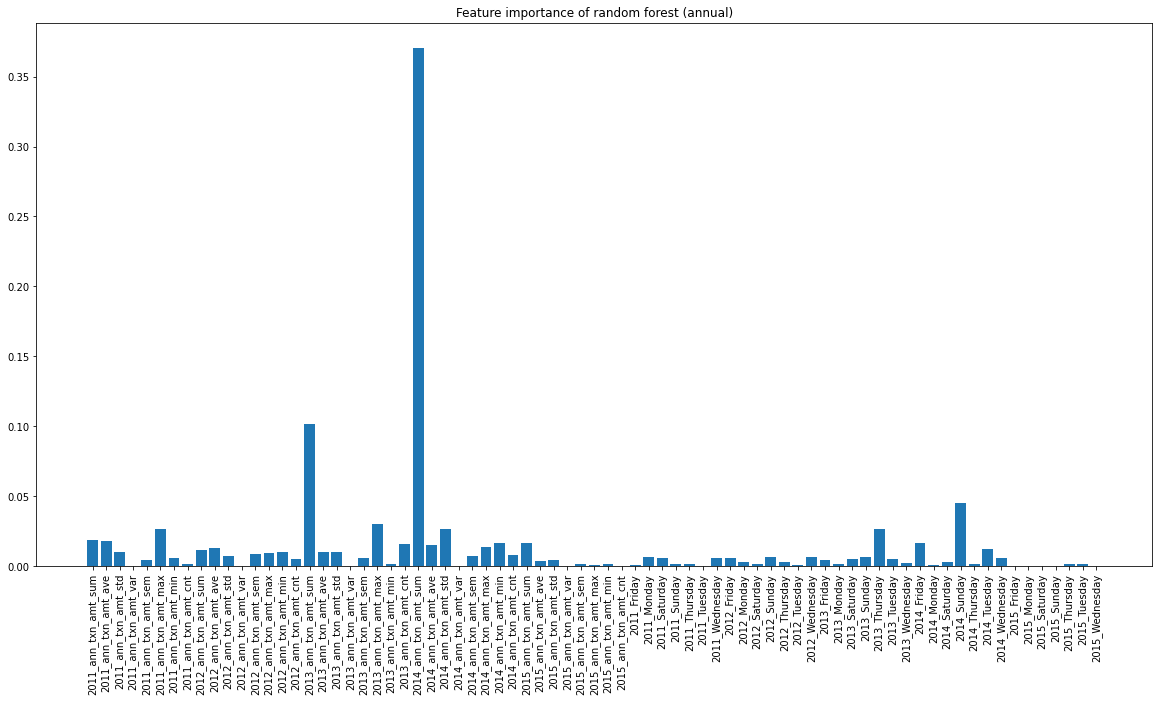

In [30]:
importances = best_model.featureImportances.toArray()
plt.figure(figsize=(20,10))
plt.bar(feature_names, importances)
plt.xticks(rotation=90)
plt.title('Feature importance of random forest (annual)')
plt.show()

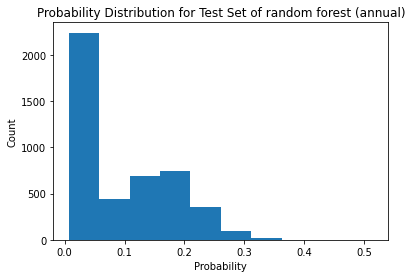

In [31]:
predictions = model_rf.transform(test_data)
test_probabilities = np.array(predictions.select('probability').collect())

plt.hist(test_probabilities[:,0][:,1], bins=10)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Probability Distribution for Test Set of random forest (annual)')
plt.show()

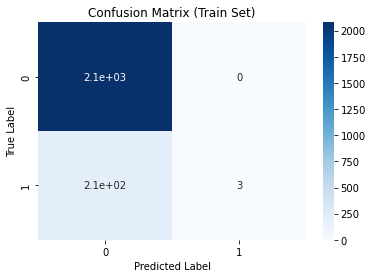

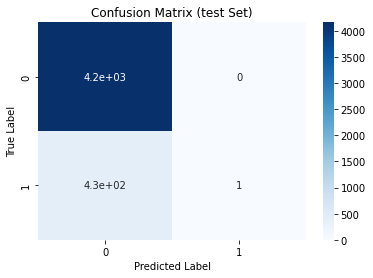

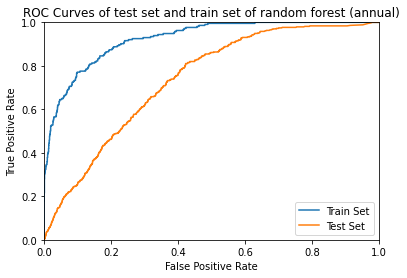

Confusion matrix of test set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    1|
|  1.0|       0.0|  432|
|  0.0|       0.0| 4163|
+-----+----------+-----+

Precision of test set:  0.9148421629822403
Recall of test set:  0.906005221932115

Confusion matrix of train set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    3|
|  1.0|       0.0|  211|
|  0.0|       0.0| 2079|
+-----+----------+-----+

Precision of train set:  0.9164594351138932
Recall of train set:  0.9079808111644134


In [105]:
test_predictions = model_rf.transform(test_data)
train_predictions = model_rf.transform(vectrain)
train_labels = np.array(train_predictions.select('label').collect())
train_probabilities = np.array(train_predictions.select('probability').collect())
test_labels = np.array(test_predictions.select('label').collect())
test_probabilities = np.array(test_predictions.select('probability').collect())

#evaluator = BinaryClassificationEvaluator(labelCol=target_col)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target_col)
# Train set
train_accuracy = evaluator.evaluate(train_predictions)
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedPrecision'})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedRecall'})
train_confusion_matrix = train_predictions.groupBy('label', 'prediction').count()

# Test set
test_accuracy = evaluator.evaluate(test_predictions)
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedPrecision'})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedRecall'})
test_confusion_matrix = test_predictions.groupBy('label', 'prediction').count()


confusionmatrix = confusion_matrix(train_labels, np.array(train_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train Set)')
plt.show()
confusionmatrix = confusion_matrix(test_labels, np.array(test_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (test Set)')
plt.show()
# ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, train_probabilities[:,0][:, 1])
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, test_probabilities[:,0][:, 1])
plt.plot(train_fpr, train_tpr, label='Train Set')
plt.plot(test_fpr, test_tpr, label='Test Set')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of test set and train set of random forest (annual)')
plt.show()
print('Confusion matrix of test set: \n')
test_confusion_matrix.show()
print('Precision of test set: ', test_precision)
print('Recall of test set: ', test_recall)
print('\nConfusion matrix of train set: \n')
train_confusion_matrix.show()
print('Precision of train set: ', train_precision)
print('Recall of train set: ',train_recall)

In [33]:
# monthly

mthrollingfeature = spark.read.format("csv").option("header", "true").load("mthrollingfeature.csv")
mthdaycounts = spark.read.format("csv").option("header", "true").load("mthdaycounts.csv")
daysincelasttxn = spark.read.format("csv").option("header", "true").load("daysincelasttxn.csv")


In [34]:
mthdaycounts = mthdaycounts.withColumnRenamed('CLNT_NO','customer_id')
mthrollingfeature = mthrollingfeature.withColumnRenamed('CLNT_NO','customer_id')
daysincelasttxn = daysincelasttxn.withColumnRenamed('CLNT_NO','customer_id')


In [35]:
mthjoin = mthrollingfeature.join(mthdaycounts,["customer_id",'ME_DT'], how = 'outer').join(daysincelasttxn, ['customer_id','ME_DT'], how = 'outer').join(retailresponse, ['customer_id'], how = 'outer')

## Logistic Regression of monthly data

In [106]:
# Load data
data = mthjoin

columns = data.columns[2:]

for i in columns:
    data = data.withColumn(i, F.col(i).cast('double'))
data1 = data.drop('customer_id','ME_DT')
data1 = data1.withColumnRenamed('response','label')
# Define the features and target column names
feature_cols = [col for col in data1.columns if col != "label"]
target_col = "label"


data1 = data1.na.fill(0)
# Split data into training and test sets
train_data, test_data = data1.randomSplit([1/3, 2/3], seed=1148)
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
vectrain = assembler.transform(train_data)
test_data = assembler.transform(test_data)

In [37]:
# Create the feature vector
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col
# assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
# vectrain = assembler.transform(train_data)
# test_data = assembler.transform(test_data)
# ElasticNetParam = 1 => L1 regularization
lr = LogisticRegression(featuresCol="features", labelCol=target_col, elasticNetParam=1.0, regParam=0.1)
print('finished lr')
# Define parameter grid for hyperparameter tuning
param_grid_m = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.001, 0.01, 0.1, 1])
              .build())
print('finished param_grid', param_grid_m)
# Create cross-validator object
cv_m = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_m, evaluator=BinaryClassificationEvaluator(), numFolds=3, seed = 1148)
print('finishend cv', cv_m)
# Fit the model on the training data
cv_model_m = cv_m.fit(vectrain)
print('finished cv_model')
# Make predictions on the test data
predictions = cv_model_m.transform(test_data)
print('finished preditions')
# Evaluate the model performance
evaluator = BinaryClassificationEvaluator(labelCol=target_col)
print('finished evaluator')
auc = evaluator.evaluate(predictions)

print("AUC:", auc)

finished lr
finished param_grid [{Param(parent='LogisticRegression_bb4b3dc5fc69', name='regParam', doc='regularization parameter (>= 0).'): 0.001}, {Param(parent='LogisticRegression_bb4b3dc5fc69', name='regParam', doc='regularization parameter (>= 0).'): 0.01}, {Param(parent='LogisticRegression_bb4b3dc5fc69', name='regParam', doc='regularization parameter (>= 0).'): 0.1}, {Param(parent='LogisticRegression_bb4b3dc5fc69', name='regParam', doc='regularization parameter (>= 0).'): 1.0}]
finishend cv CrossValidator_10f0c6b76f6f
finished cv_model
finished preditions
finished evaluator
AUC: 0.6238935558363331


In [107]:
best_model = cv_model_m.bestModel
print(f"Best hyperparameters: regParam = {best_model._java_obj.getRegParam()}, elasticNetParam = {best_model._java_obj.getElasticNetParam()}, maxIter = {best_model._java_obj.getMaxIter()}")


Best hyperparameters: regParam = 0.001, elasticNetParam = 1.0, maxIter = 100


In [39]:
# lr = LogisticRegression(featuresCol="features", labelCol=target_col, elasticNetParam=1.0, regParam=0.1)
# print('finished lr')
# # Define parameter grid for hyperparameter tuning
# param_grid_m = (ParamGridBuilder()
#               .addGrid(lr.regParam, [0.005, 0.0001])
#               .build())
# print('finished param_grid', param_grid_m)
# # Create cross-validator object
# cv_m = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_m, evaluator=BinaryClassificationEvaluator(), numFolds=3, seed = 1148)
# print('finishend cv', cv_m)
# # Fit the model on the training data
# cv_model_m = cv_m.fit(vectrain)
# print('finished cv_model')
# # Make predictions on the test data
# predictions = cv_model_m.transform(test_data)
# print('finished preditions')
# # Evaluate the model performance
# evaluator = BinaryClassificationEvaluator(labelCol=target_col)
# print('finished evaluator')
# auc = evaluator.evaluate(predictions)

# print("AUC:", auc)

In [40]:
# best_model = cv_model_m.bestModel
# print(f"Best hyperparameters: regParam = {best_model._java_obj.getRegParam()}, elasticNetParam = {best_model._java_obj.getElasticNetParam()}, maxIter = {best_model._java_obj.getMaxIter()}")


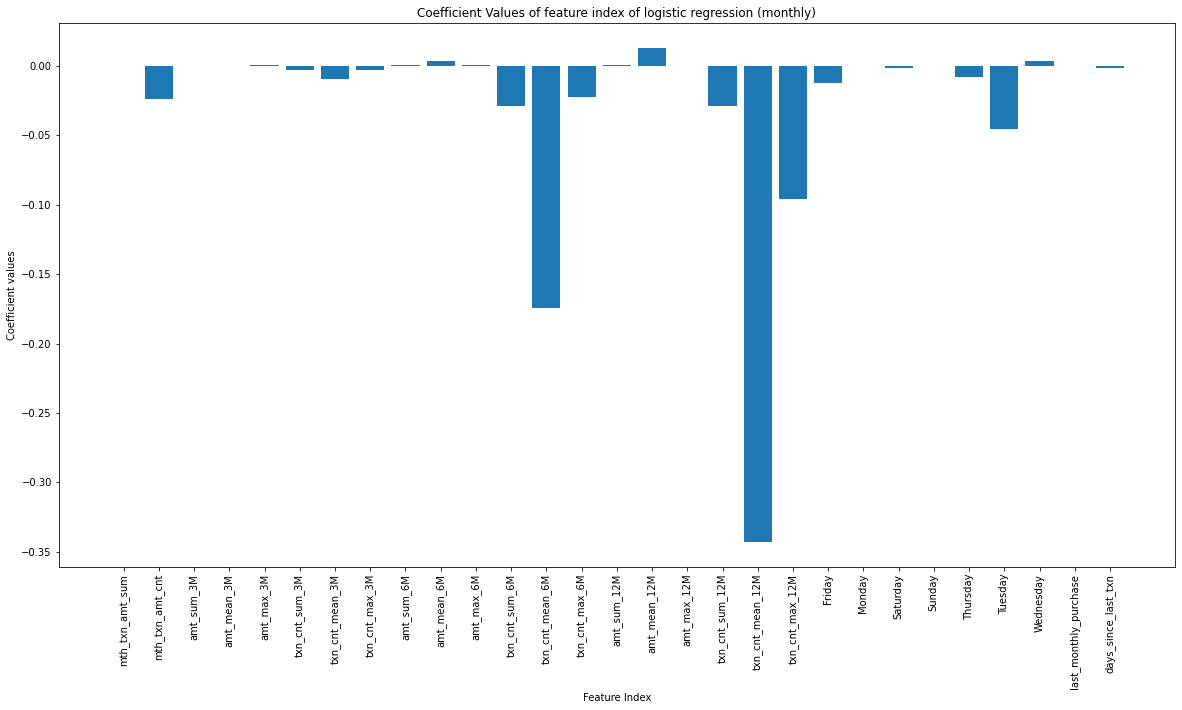

In [41]:
# Import necessary libraries

import matplotlib.pyplot as plt

# Load dataset




# Extract coefficient values and feature names
coefficients = best_model.coefficients
intercept = best_model.intercept
feature_names = data1.columns[0:len(data1.columns)-1]

# Plot coefficients
plt.figure(figsize=(20, 10))
plt.bar(feature_names,coefficients)
plt.xticks(rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Coefficient values')
plt.title("Coefficient Values of feature index of logistic regression (monthly)")
plt.show()

# # Plot feature importance
# abs_coefficients = [abs(x) for x in coefficients]
# plt.bar(feature_names, abs_coefficients)
# plt.xticks(rotation=90)
# plt.title("Feature Importance")
# plt.show()


Text(0.5, 1.0, 'Probability Distribution for Test Set of logistic regression (monthly)')

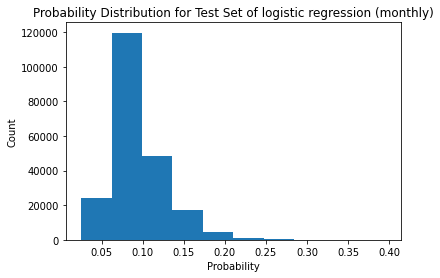

In [42]:
# from pyspark.ml.evaluation import BinaryLogisticRegressionSummary
from pyspark.ml.classification import BinaryLogisticRegressionSummary
import numpy as np
predictions = cv_model_m.transform(test_data)
test_probabilities = np.array(predictions.select('probability').collect())

plt.hist(test_probabilities[:,0][:,1], bins=10)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Probability Distribution for Test Set of logistic regression (monthly)')
# summary = BinaryLogisticRegressionSummary(predictions, 'probability', 'label')
# Get the probability distribution for the test set
# prob_dist = summary.roc.toPandas()

# # Plot the probability distribution
# plt.plot(prob_dist['FPR'], prob_dist['TPR'])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Probability Distribution for Test Set')
# plt.show()

In [108]:
test_predictions = cv_model_m.transform(test_data)
train_predictions = cv_model_m.transform(vectrain)
train_labels = np.array(train_predictions.select('label').collect())
train_probabilities = np.array(train_predictions.select('probability').collect())
test_labels = np.array(test_predictions.select('label').collect())
test_probabilities = np.array(test_predictions.select('probability').collect())

#evaluator = BinaryClassificationEvaluator(labelCol=target_col)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target_col)
# Train set
train_accuracy = evaluator.evaluate(train_predictions)
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedPrecision'})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedRecall'})
train_confusion_matrix = train_predictions.groupBy('label', 'prediction').count()

# Test set
test_accuracy = evaluator.evaluate(test_predictions)
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedPrecision'})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedRecall'})
test_confusion_matrix = test_predictions.groupBy('label', 'prediction').count()

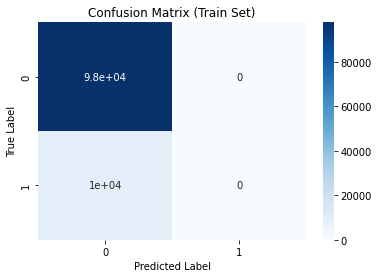

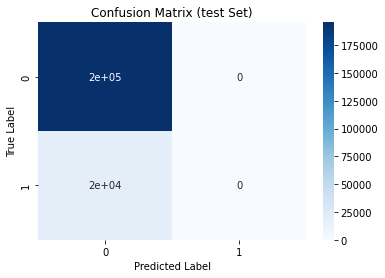

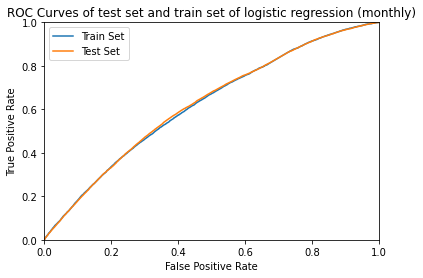

In [109]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

confusionmatrix = confusion_matrix(train_labels, np.array(train_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train Set)')
plt.show()
confusionmatrix = confusion_matrix(test_labels, np.array(test_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (test Set)')
plt.show()
# ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, train_probabilities[:,0][:, 1])
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, test_probabilities[:,0][:, 1])
plt.plot(train_fpr, train_tpr, label='Train Set')
plt.plot(test_fpr, test_tpr, label='Test Set')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of test set and train set of logistic regression (monthly)')
plt.show()

In [45]:
print('Confusion matrix of test set: \n')
test_confusion_matrix.show()
print('Precision of test set: ', test_precision)
print('Recall of test set: ', test_recall)
print('\nConfusion matrix of train set: \n')
train_confusion_matrix.show()
print('Precision of train set: ', train_precision)
print('Recall of train set: ',train_recall)

Confusion matrix of test set: 

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       0.0| 20347|
|  0.0|       0.0|195524|
+-----+----------+------+

Precision of test set:  0.8203733429746333
Recall of test set:  0.9057446345271019

Confusion matrix of train set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|10062|
|  0.0|       0.0|97850|
+-----+----------+-----+

Precision of train set:  0.8222089060099167
Recall of train set:  0.9067573578471347


## Decision Tree Model of Monthly Data

In [46]:
## Decision Tree Model of Monthly Data

In [47]:
# tree ex 2
# rough search decision tree parameters
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid_dt_m = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 15, 25]) \
    .addGrid(dt.maxBins, [5, 15, 25]) \
    .addGrid(dt.impurity, ['gini', 'entropy']) \
    .build()
evaluator_dt = BinaryClassificationEvaluator(labelCol="label")
cv_dt_m = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt_m, evaluator=evaluator_dt, numFolds=5, seed = 1148)
model_dt_m = cv_dt_m.fit(vectrain)
predictions = model_dt_m.transform(test_data)
auc = evaluator_dt.evaluate(predictions)
print("Prediction = %g" % auc)



Prediction = 0.604093


In [110]:
# show parameters after the rough tuning of decision tree model
best_model = model_dt_m.bestModel
print(f"Best hyperparameters: maxDepth = {best_model._java_obj.getMaxDepth()}, \
      maxBin = {best_model._java_obj.getMaxBins()}, \
      impurity = {best_model._java_obj.getImpurity()}")

Best hyperparameters: maxDepth = 5,       maxBin = 5,       impurity = gini


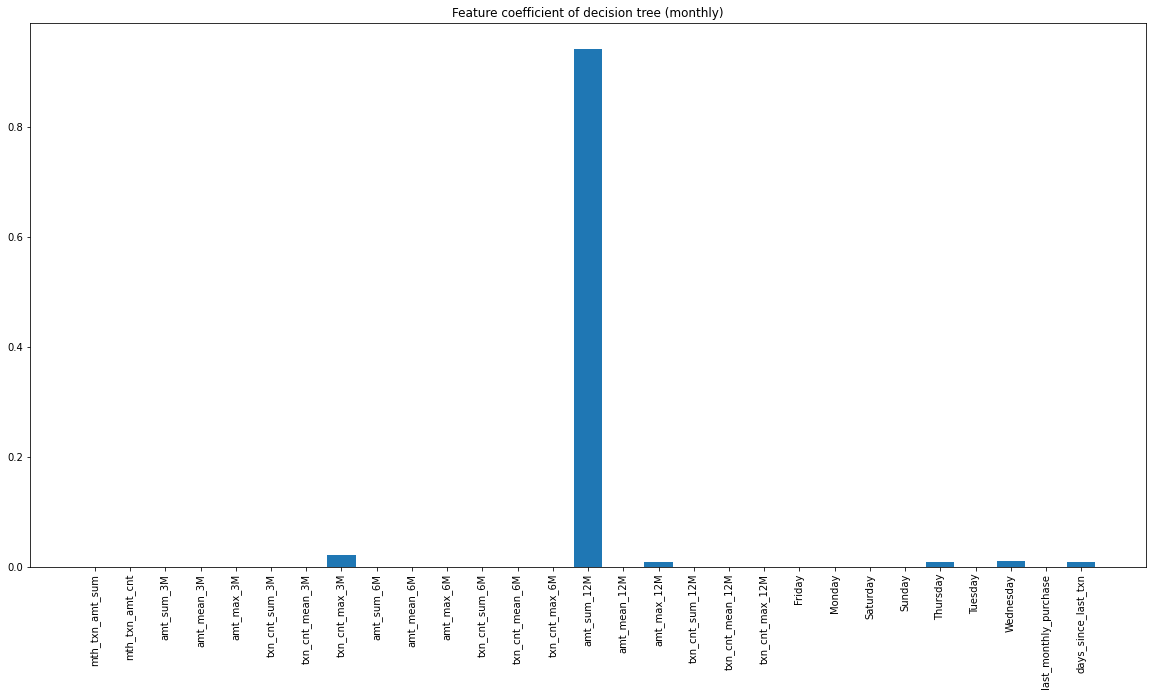

In [49]:
importances = best_model.featureImportances.toArray()
plt.figure(figsize=(20,10))
plt.bar(feature_names, importances)
plt.xticks(rotation=90)
plt.title('Feature coefficient of decision tree (monthly)')
plt.show()

Text(0.5, 1.0, 'Probability Distribution for Test Set of decision tree (monthly)')

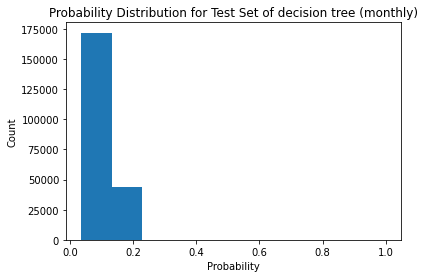

In [50]:
# probability distribution
predictions = model_dt_m.transform(test_data)
test_probabilities = np.array(predictions.select('probability').collect())

plt.hist(test_probabilities[:,0][:,1], bins=10)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Probability Distribution for Test Set of decision tree (monthly)')

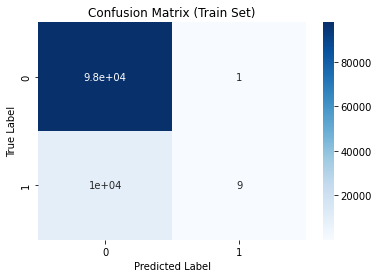

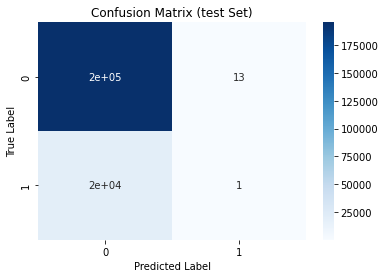

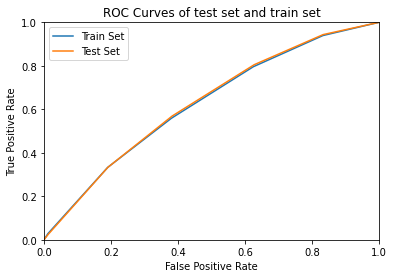

Confusion matrix of test set: 

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  1.0|       1.0|     1|
|  0.0|       1.0|    13|
|  1.0|       0.0| 20346|
|  0.0|       0.0|195511|
+-----+----------+------+

Precision of test set:  0.8271045281298262
Recall of test set:  0.9056890457727069

Confusion matrix of train set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    9|
|  0.0|       1.0|    1|
|  1.0|       0.0|10053|
|  0.0|       0.0|97849|
+-----+----------+-----+

Precision of train set:  0.9061950800189515
Recall of train set:  0.9068314923270814


In [111]:
test_predictions = model_dt_m.transform(test_data)
train_predictions = model_dt_m.transform(vectrain)
train_labels = np.array(train_predictions.select('label').collect())
train_probabilities = np.array(train_predictions.select('probability').collect())
test_labels = np.array(test_predictions.select('label').collect())
test_probabilities = np.array(test_predictions.select('probability').collect())

#evaluator = BinaryClassificationEvaluator(labelCol=target_col)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target_col)
# Train set
train_accuracy = evaluator.evaluate(train_predictions)
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedPrecision'})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedRecall'})
train_confusion_matrix = train_predictions.groupBy('label', 'prediction').count()

# Test set
test_accuracy = evaluator.evaluate(test_predictions)
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedPrecision'})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedRecall'})
test_confusion_matrix = test_predictions.groupBy('label', 'prediction').count()


confusionmatrix = confusion_matrix(train_labels, np.array(train_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train Set)')
plt.show()
confusionmatrix = confusion_matrix(test_labels, np.array(test_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (test Set)')
plt.show()
# ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, train_probabilities[:,0][:, 1])
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, test_probabilities[:,0][:, 1])
plt.plot(train_fpr, train_tpr, label='Train Set')
plt.plot(test_fpr, test_tpr, label='Test Set')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of test set and train set')
plt.show()
print('Confusion matrix of test set: \n')
test_confusion_matrix.show()
print('Precision of test set: ', test_precision)
print('Recall of test set: ', test_recall)
print('\nConfusion matrix of train set: \n')
train_confusion_matrix.show()
print('Precision of train set: ', train_precision)
print('Recall of train set: ',train_recall)

## Random Forest Model of Monthly Data

In [52]:

# random forest
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid_rf_m = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.impurity, ['gini','entropy']) \
    .addGrid(rf.featureSubsetStrategy, ['auto','all','sqrt','log2']) \
        .build()
    #.addGrid(rf.maxDepth, [2, 4, 6]) \
    #.addGrid(rf.minInstancesPerNode, [1, 2, 3]) \
evaluator_rf = BinaryClassificationEvaluator(labelCol="label")
cv_rf_m = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf_m, evaluator=evaluator_rf, numFolds=3, seed = 1148)
# pipeline = Pipeline(stages=[assembler, cv])
model_rf_m = cv_rf_m.fit(vectrain)
# model = rf.fit(trainData)
predictions = model_rf_m.transform(test_data)
auc = evaluator_rf.evaluate(predictions)
print("Area under ROC curve = %g" % auc)

# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_rf.evaluate(predictions)

print("Accuracy:", accuracy)
#bestModel = model.stages[1].bestModel
#newPredictions = bestModel.transform(newData)



Area under ROC curve = 0.63775
Accuracy: 0.6377497649622467


In [112]:
# show parameters after tuning random forest 
best_model = model_rf_m.bestModel
print(f"Best hyperparameters: numTrees = {best_model._java_obj.getNumTrees()} \
      impurity = {best_model._java_obj.getImpurity()} \
      minInstancesPerNode = {best_model._java_obj.getMinInstancesPerNode()} \
      featureSubsetStrategy = {best_model._java_obj.getFeatureSubsetStrategy()}")



Best hyperparameters: numTrees = 30       impurity = gini       minInstancesPerNode = 1       featureSubsetStrategy = all


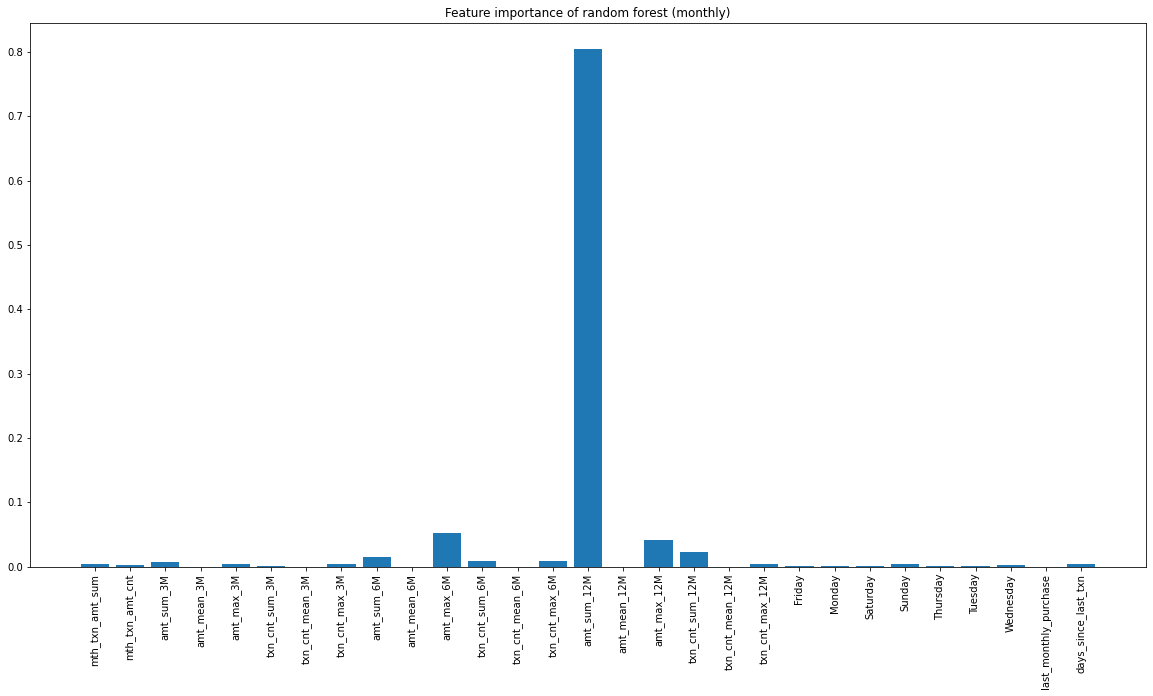

In [54]:
importances = best_model.featureImportances.toArray()
plt.figure(figsize=(20,10))
plt.bar(feature_names, importances)
plt.xticks(rotation=90)
plt.title('Feature importance of random forest (monthly)')
plt.show()

Text(0.5, 1.0, 'Probability Distribution for Test Set of random forest (monthly)')

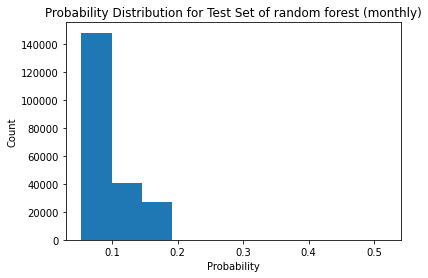

In [55]:
predictions = model_rf_m.transform(test_data)
test_probabilities = np.array(predictions.select('probability').collect())

plt.hist(test_probabilities[:,0][:,1], bins=10)

# Add labels and title
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Probability Distribution for Test Set of random forest (monthly)')

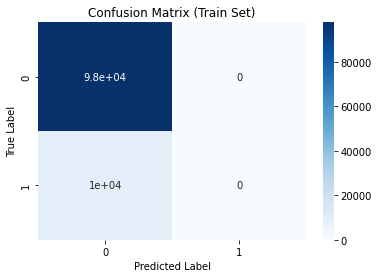

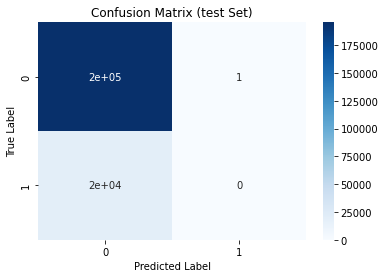

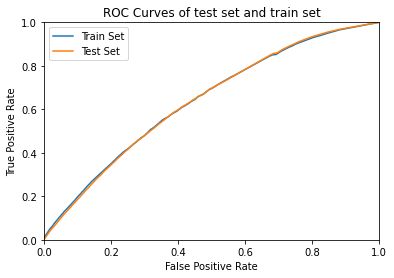

Confusion matrix of test set: 

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       1.0|     1|
|  1.0|       0.0| 20347|
|  0.0|       0.0|195523|
+-----+----------+------+

Precision of test set:  0.8203729474991548
Recall of test set:  0.9057400021309022

Confusion matrix of train set: 

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|10062|
|  0.0|       0.0|97850|
+-----+----------+-----+

Precision of train set:  0.8222089060099167
Recall of train set:  0.9067573578471347


In [113]:
import numpy as np
test_predictions = model_rf_m.transform(test_data)
train_predictions = model_rf_m.transform(vectrain)
train_labels = np.array(train_predictions.select('label').collect())
train_probabilities = np.array(train_predictions.select('probability').collect())
test_labels = np.array(test_predictions.select('label').collect())
test_probabilities = np.array(test_predictions.select('probability').collect())

#evaluator = BinaryClassificationEvaluator(labelCol=target_col)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=target_col)
# Train set
train_accuracy = evaluator.evaluate(train_predictions)
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedPrecision'})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: 'weightedRecall'})
train_confusion_matrix = train_predictions.groupBy('label', 'prediction').count()

# Test set
test_accuracy = evaluator.evaluate(test_predictions)
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedPrecision'})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: 'weightedRecall'})
test_confusion_matrix = test_predictions.groupBy('label', 'prediction').count()


confusionmatrix = confusion_matrix(train_labels, np.array(train_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train Set)')
plt.show()
confusionmatrix = confusion_matrix(test_labels, np.array(test_predictions.select('prediction').collect()))
sns.heatmap(confusionmatrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (test Set)')
plt.show()
# ROC curves
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, train_probabilities[:,0][:, 1])
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, test_probabilities[:,0][:, 1])
plt.plot(train_fpr, train_tpr, label='Train Set')
plt.plot(test_fpr, test_tpr, label='Test Set')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of test set and train set')
plt.show()
print('Confusion matrix of test set: \n')
test_confusion_matrix.show()
print('Precision of test set: ', test_precision)
print('Recall of test set: ', test_recall)
print('\nConfusion matrix of train set: \n')
train_confusion_matrix.show()
print('Precision of train set: ', train_precision)
print('Recall of train set: ',train_recall)

In [60]:
f1_1_t_a = 2 * 0.8458792289513161 * 0.9038294168842472 / (0.8458792289513161 + 0.9038294168842472)
f1_1_tr_a = 2 * 0.8456351000452114 * 0.9058002616659397 / (0.8456351000452114 + 0.9058002616659397)
f1_2_t_a = 2 * 0.8443581400743573 * 0.8598781549173194 / (0.8443581400743573 + 0.8598781549173194)
f1_2_tr_a =  2 * 0.9644901267891343 * 0.9655473179241169 / (0.9644901267891343 + 0.9655473179241169)
f1_3_t_a = 2 * 0.9148421629822403 * 0.906005221932115 / (0.9148421629822403 + 0.906005221932115)
f1_3_tr_a = 2 * 0.9164594351138932 * 0.9079808111644134 / (0.9164594351138932 + 0.9079808111644134)

f1_1_t_m = 2 * 0.8203733429746333 * 0.9057446345271019 / (0.8203733429746333 + 0.9057446345271019)
f1_1_tr_m = 2 * 0.8222089060099167 * 0.9067573578471347 / (0.8222089060099167 + 0.9067573578471347)
f1_2_t_m = 2 * 0.8271045281298262 * 0.9056890457727069 / (0.8271045281298262 + 0.9056890457727069)
f1_2_tr_m =  2 * 0.9061950800189515 * 0.9068314923270814 / (0.9061950800189515 + 0.9068314923270814)
f1_3_t_m = 2 * 0.8203729474991548 * 0.9057400021309022 / 90.8203729474991548 + 0.9057400021309022
f1_3_tr_m = 2 * 0.8222089060099167 * 0.9067573578471347 / (0.8222089060099167 + 0.9067573578471347)


In [67]:
print('Annual data')
print('L1 regression f1 (test)', 'L1 regression f1 (train)', 'Decision tree f1 (test)','Decision tree f1 (train)', 'Random forest f1 (test)','Random forest f1 (train)')
print(f1_1_t_a,f1_1_tr_a,f1_2_t_a,f1_2_tr_a,f1_3_t_a,f1_3_tr_a)

Annual data
Linear regression f1 (test) Linear regression f1 (train) Decision tree f1 (test) Decision tree f1 (train) Random forest f1 (test) Random forest f1 (train)
0.8738946704952327 0.8746842865459756 0.852047479226 0.9650184328148089 0.9104022487250533 0.9122004220104856


In [66]:
print('Monthly data')
print('L1 regression f1 (test)', 'L1 regression f1 (train)', 'Decision tree f1 (test)','Decision tree f1 (train)', 'Random forest f1 (test)','Random forest f1 (train)')
print(f1_1_t_m,f1_1_tr_m,f1_2_t_m,f1_2_tr_m,f1_3_t_m,f1_3_tr_m)

Monthly data
Linear regression f1 (test) Linear regression f1 (train) Decision tree f1 (test) Decision tree f1 (train) Random forest f1 (test) Random forest f1 (train)
0.8609478186233526 0.862415873342426 0.8646148302005684 0.9065131744756392 0.9221029517885865 0.862415873342426


|               | Annual data (test)|  Monthly data     (test)   | Annual data (train)   |Monthly data (train)| 
| ------------- | ------------- | ---------|---|---|
| L1 regression  | 0.8738946704952327   |      0.8609478186233526     |0.8746842865459756 |  0.862415873342426|
| Decision tree  | 0.852047479226   |      0.8646148302005684     |0.9650184328148089 |  0.9065131744756392 |
|Random forest  |     0.9104022487250533            |0.9221029517885865 | 0.9122004220104856|0.862415873342426|

#### The f1 score of annual data and monthly data are shown with respect to each model in both training and test set. It is witnessed that the f1 score of Decision tree model on annual training data is the highest, with a value of 0.965; the two highets f1 score in test set are random forest model on monthly data and random forest model on annual data respectively. Although the monthly random forest has the highest f1 score in test set, but its f1 score on training set data is only 0.86; on the other hand, the random forest model with respect to annual data has similar f1 scores in training and testing data. By leveraging both training and test f1 scores, the Random forest model on annual data should be adopted due to its consistent high performance on test and training data. Also, annual data is more efficient to be calculated since it has fewer features.